In [111]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
warnings.filterwarnings('ignore')

column_names = ['age', 'workclass', 'fnlwgt', 'education', 'educational-num',
                'marital-status', 'occupation', 'relationship', 'race', 'gender',
                'capital-gain', 'capital-loss', 'hours-per-week', 'native-country','income']


adult_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

adult_test_df = pd.read_csv("data/adult_training.csv",
                      delimiter=",",
                      skipinitialspace=True,
                      names = column_names,
                      dtype=None)

from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix



from sklearn.model_selection import train_test_split
from __future__ import division
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.utils import resample
from sklearn.ensemble import BaggingClassifier

from joblib import dump, load
from sklearn.model_selection import cross_val_score
import sys

from pandas.tools.plotting import table
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import Dropout
# from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [74]:
def adult_preprocess(df, balanced=False, impute=False):
    """adult_preprocess(df, balanced=False, impute=False)
            balanced: will sample an even amount of data from each
    
            impute:
                Imputes missing data using random forest,
                or removes rows with missing data
                
        expands categorical data returns X and Y arrays"""
    #drop columns
    drop_columns = ["fnlwgt"]
    df = df.drop(drop_columns , axis=1)
    
    from sklearn.ensemble import RandomForestClassifier
    from sklearn import tree
    
    
    if impute:
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.workclass
        impute_df.drop(columns = ['workclass'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.workclass.values == '?')].copy()
        
        train_data = impute_df[(df.workclass.values != '?')].copy()
        train_label = impute_labels[(df.workclass.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.workclass.values == '?'),'workclass'] = random_forest_pred
        
        #repeat for occupation
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df.occupation
        impute_df.drop(columns = ['occupation'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df.occupation.values == '?')].copy()
        
        train_data = impute_df[(df.occupation.values != '?')].copy()
        train_label = impute_labels[(df.occupation.values != '?')]
     
        random_forest = RandomForestClassifier(n_estimators=10)
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df.occupation.values == '?'),'occupation'] = random_forest_pred
        
        # repeat for native-country
        
        impute_df = df.copy()
        impute_df.drop(columns = ['income'], inplace=True)
        
        impute_labels = impute_df['native-country']
        impute_df.drop(columns = ['native-country'], inplace=True)
        
        impute_df = pd.get_dummies(impute_df)
        
        test_data = impute_df[(df['native-country'].values == '?')].copy()
        
        train_data = impute_df[(df['native-country'].values != '?')].copy()
        train_label = impute_labels[(df['native-country'].values != '?')]
     
        random_forest = tree.DecisionTreeClassifier()
        random_forest = random_forest.fit(train_data, train_label)
        random_forest_pred = random_forest.predict(test_data)    
        df.loc[(df['native-country'].values == '?'),'native-country'] = random_forest_pred    
    else:
        # remove rows with '?'s
        df = df[(df != '?').all(1)]
    
    # convert categorical data into one-hot
    df_one_hot = pd.get_dummies(df)
    
    # sample equal number of plus and minus
    if balanced:
        # find number of income > $50k
        sample_number = len(df_one_hot[df_one_hot['income_>50K'] == 1])
        df_over_50k = df_one_hot[df_one_hot['income_>50K'] == 1].sample(n=sample_number, random_state=0)
        df_under_50k = df_one_hot[df_one_hot['income_>50K'] == 0].sample(n=sample_number, random_state=0)
        frames = [df_over_50k, df_under_50k]
        df_clean = pd.concat(frames)
    else:
        df_clean = df_one_hot
    
    #randomize data order
    df_clean = df_clean.sample(frac=1)
    
    # split into inputs and targets
    X = df_clean.iloc[:,0:-2].values
    Y = df_clean.loc[:,'income_>50K'].values
    
    return X, Y

In [75]:
def performance_metrics(y_true, y_pred):
    
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    
    TP = cm[1,1]
    TN = cm[0,0]
    FP = cm[0,1]
    FN = cm[1,0]

    accuracy = ((TP+TN))/(TP+FN+FP+TN)
    precision = (TP)/(TP+FP)
    recall = (TP)/(TP+FN)
    f_measure = (2*recall*precision)/(recall+precision)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)
    error_rate = 1 - accuracy
    false_pos = FP/(FP+TN)
    
    metrics = {}
    metrics['accuracy'] =  accuracy
    metrics['precision'] = precision
    metrics['recall'] = recall
    metrics['f_measure'] = f_measure
    metrics['sensitivity'] = sensitivity
    metrics['specificity'] = specificity
    metrics['error_rate'] = error_rate
    metrics['false_pos'] = false_pos
    
    return metrics

In [76]:
X, Y = adult_preprocess(adult_df, balanced=False, impute=True)
scaler = StandardScaler()  # Default behavior is to scale to [0,1]
X = scaler.fit_transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state = 0)

X_test, Y_test = adult_preprocess(adult_test_df, balanced=False, impute=True)
X_test = scaler.fit_transform(X_test)


## Decision tree

Max is at 0.01000: 0.86 


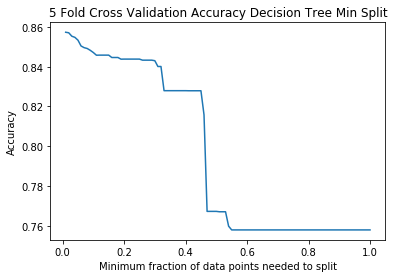

In [48]:
min_samples_splits = np.linspace(0.01, 1.0, 100, endpoint=True)

min_samples_leaf = 1
acc = np.zeros(100)
i = 0
for split in min_samples_splits:
        clf = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = split,
                              min_samples_leaf = min_samples_leaf)
        scores = cross_val_score(clf, X_train, Y_train, cv=5)
#         print("Accuracy with a min_samples %0.5f: %0.2f (+/- %0.2f)" % (split ,scores.mean(), scores.std() * 2))
        acc[i] = scores.mean()
        i += 1
        sys.stdout.flush()
        
index = np.argmax(acc)

print("Max is at %0.5f: %0.2f " % (min_samples_splits[index], acc[index]))

plt.plot(min_samples_splits,acc)
plt.xlabel("Minimum fraction of data points needed to split")
plt.ylabel("Accuracy")
plt.title("5 Fold Cross Validation Accuracy Decision Tree Min Split")
plt.savefig("minSplit.png")

Max is at 0.00100: 0.85 


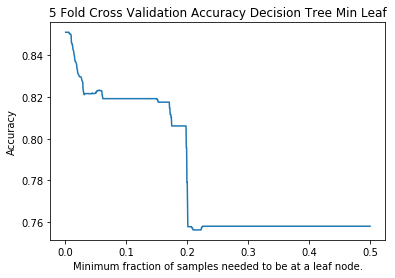

In [109]:
min_samples_leafs = np.linspace(0.001, 0.5, 1000, endpoint=True)
# min_samples_leaf = 1
split = 0.1
acc = np.zeros(1000)
i = 0
for leafs in min_samples_leafs:
        clf = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = split,
                              min_samples_leaf = leafs)
        scores = cross_val_score(clf, X_train, Y_train, cv=5)
#         print("Accuracy with a min_leafs %0.5f: %0.2f (+/- %0.2f)" % (leafs ,scores.mean(), scores.std() * 2))
        acc[i] = scores.mean()
        i += 1
        sys.stdout.flush()

index = np.argmax(acc)

print("Max is at %0.5f: %0.2f " % (min_samples_leafs[index], acc[index]))
plt.plot(min_samples_leafs,acc)
plt.xlabel("Minimum fraction of samples needed to be at a leaf node.")
plt.ylabel("Accuracy")
plt.title("5 Fold Cross Validation Accuracy Decision Tree Min Leaf")
plt.savefig("minLeaf.png")

In [129]:
min_samples_split = 0.05 #default value
min_samples_leaf = 0.001  # default value
# results = dic()


# gini tree

g_tree = DecisionTreeClassifier(criterion = 'gini', 
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf)

g_tree.fit(X_train,Y_train)

g_test_predict = g_tree.predict(X_test)

DTree_Gini_Test = performance_metrics(Y_test,g_test_predict)



# entropy tree

e_tree = DecisionTreeClassifier(criterion = 'entropy', 
                              min_samples_split = min_samples_split,
                              min_samples_leaf = min_samples_leaf)

e_tree.fit(X_train,Y_train)

e_test_predict = e_tree.predict(X_test)

DTree_Entropy_Test = performance_metrics(Y_test,e_test_predict)


ovl_dtree = pd.DataFrame([DTree_Gini_Test, DTree_Entropy_Test], 
                         index = ['DTree_Gini', 'DTree_Entropy'])

ovl_dtree.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

display(ovl_dtree.round(4))

,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
DTree_Gini,0.8568,0.1432,0.6565,0.0517,0.7773,0.5683,0.5683,0.9483
DTree_Entropy,0.8561,0.1439,0.6549,0.0521,0.7753,0.5669,0.5669,0.9479


## Random Forest

Max is at 1.00000: 0.86 


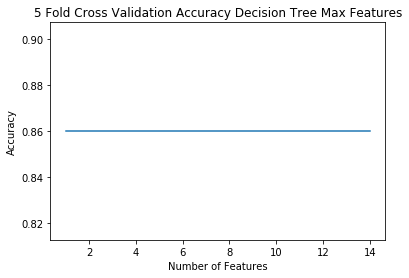

In [45]:
# n_features = np.linspace(1, 14, 14, endpoint=True)

# min_samples_split = 0.01 #value found in decision tree
# min_samples_leaf = 0.1  # value found in decision tree
# min_samples_leaf = 1
# split = 0.1
# acc = np.zeros(14)
# i = 0
# for features in n_features:
#         clf = RandomForestClassifier(n_estimators = 10,
#                                 criterion = 'gini', 
#                               min_samples_split = min_samples_split,
#                               min_samples_leaf = min_samples_leaf,
#                                max_features = None)
#         scores = cross_val_score(clf, X_train, Y_train, cv=5)
# #         print("Accuracy with a min_leafs %0.5f: %0.2f (+/- %0.2f)" % (features ,scores.mean(), scores.std() * 2))
#         acc[i] = round(scores.mean(),2)
#         i += 1
#         sys.stdout.flush()
        
# print("Max is at %0.5f: %0.2f " % (n_features[index], acc[index]))
# plt.plot(n_features,acc)
# plt.xlabel("Number of Features")
# plt.ylabel("Accuracy")
# plt.title("5 Fold Cross Validation Accuracy Decision Tree Max Features")
# plt.savefig("maxFeatures.png")

In [130]:
min_samples_split = 0.05 #value found in decision tree
min_samples_leaf = 0.001  # value found in decision tree
n_estimators = 10 # default
bootstrap = True
acc = list()
# gini tree

accuracy = np.zeros(10)

for n_estimators in range(10,101,10):
    
    g_tree = RandomForestClassifier(n_estimators = n_estimators,
                                    criterion = 'gini', 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                   max_features = None,
                                   bootstrap = bootstrap)

    g_tree.fit(X_train,Y_train)


        
    g_predict_test = g_tree.predict(X_test)

    
    

    # entropy tree


    e_tree = RandomForestClassifier(n_estimators = n_estimators,
                                    criterion = 'entropy', 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf,
                                   max_features = None,
                                   bootstrap = bootstrap)


    
    

    e_tree.fit(X_train,Y_train)
    
    e_predict_test = e_tree.predict(X_test)
    
#     acc.append(e_tree.score(X_test,Y_test))
    
    DTree_G_Test = performance_metrics(Y_test, g_predict_test)


    DTree_E_Test = performance_metrics(Y_test, e_predict_test)

    temp_dtree = pd.DataFrame([DTree_G_Test, DTree_E_Test], 
                         index = ['DTree_Gini ' + str(n_estimators), 'DTree_Entropy ' +str(n_estimators)])
    
    ovl_dtree = pd.concat([ovl_dtree,temp_dtree])

    
# classifier = LogisticRegression(random_state=0)
# classifier.fit(X_train,Y_train)

# predictclassifier.predict(X_test)
# classs = performance_metrics()
# temp_dtree = pd.DataFrame([, DTree_Entropy_Test], 
#                          index = ['DTree_Gini_Test' + str(n_estimators), 'DTree_Entropy_Test' +str(n_estimators)])
    


In [131]:
ovl_dtree.sort_values(by = ['f_measure', 'accuracy'], ascending = False, inplace = True)

display(ovl_dtree.round(4))

,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
DTree_Gini,0.8568,0.1432,0.6565,0.0517,0.7773,0.5683,0.5683,0.9483
DTree_Entropy,0.8561,0.1439,0.6549,0.0521,0.7753,0.5669,0.5669,0.9479
DTree_Gini 80,0.8566,0.1434,0.6514,0.0481,0.7858,0.5563,0.5563,0.9519
DTree_Gini 70,0.8561,0.1439,0.6500,0.0484,0.7844,0.5549,0.5549,0.9516
DTree_Entropy 20,0.8565,0.1435,0.6500,0.0473,0.7877,0.5532,0.5532,0.9527
DTree_Entropy 10,0.8551,0.1449,0.6492,0.0502,0.7785,0.5567,0.5567,0.9498
DTree_Entropy 60,0.8542,0.1458,0.6450,0.0493,0.7796,0.5501,0.5501,0.9507
DTree_Entropy 50,0.8533,0.1467,0.6418,0.0492,0.7786,0.5458,0.5458,0.9508
DTree_Gini 10,0.8520,0.1480,0.6416,0.0522,0.7696,0.5501,0.5501,0.9478
DTree_Gini 100,0.8545,0.1455,0.6410,0.0456,0.7897,0.5393,0.5393,0.9544


In [132]:
import six

def render_mpl_table(data, col_width=3.0, row_height=0.625, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in  six.iteritems(mpl_table._cells):
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
        else:
            cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
    return ax



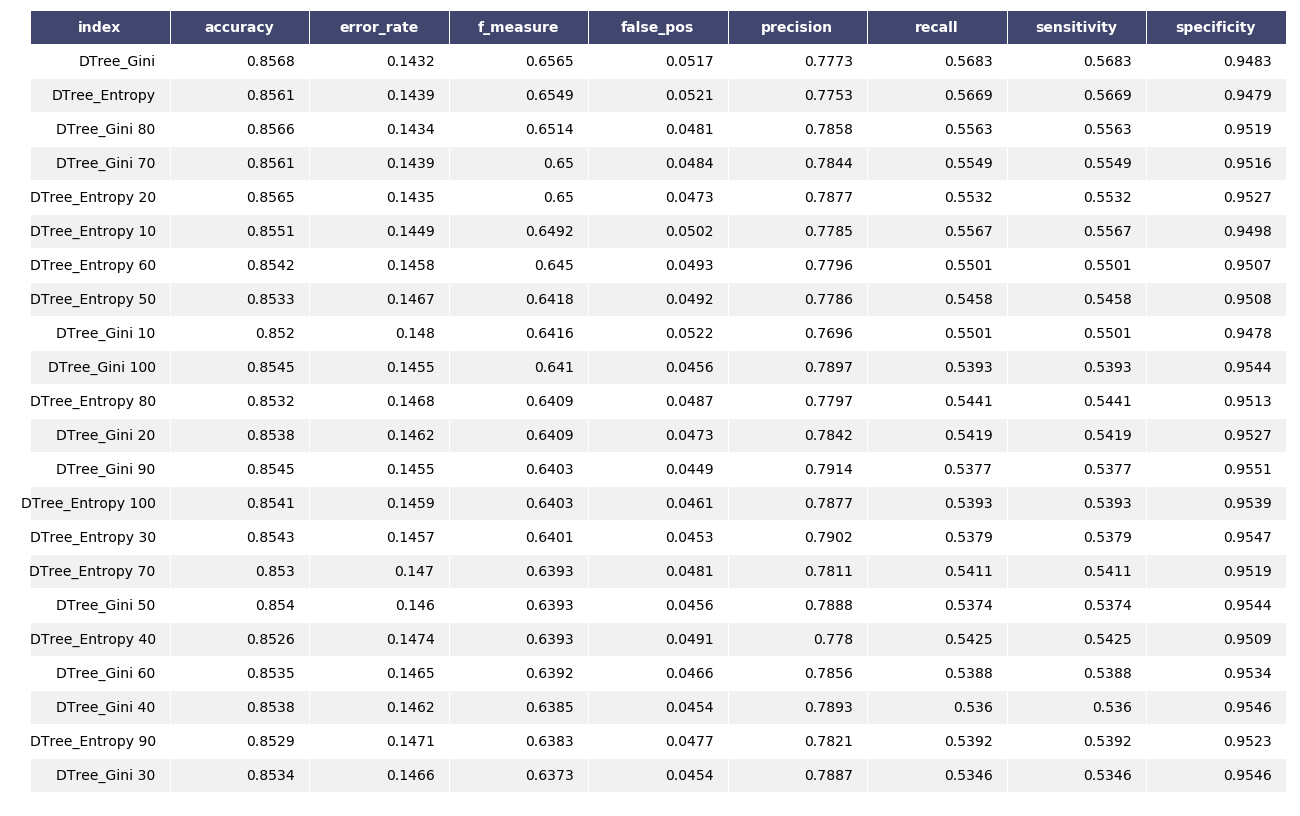

In [135]:
render_mpl_table(ovl_dtree.round(4).reset_index(), header_columns=0, col_width=2.5)
plt.savefig("decision_tree_table.png")


In [136]:
export_csv = ovl_dtree.round(4).reset_index().to_csv ('./dTreeDataFrame.csv', index = None, header=True)
test = pd.read_csv('./dTreeDataFrame.csv')

In [137]:
display(test)

,index,accuracy,error_rate,f_measure,false_pos,precision,recall,sensitivity,specificity
0,DTree_Gini,0.8568,0.1432,0.6565,0.0517,0.7773,0.5683,0.5683,0.9483
1,DTree_Entropy,0.8561,0.1439,0.6549,0.0521,0.7753,0.5669,0.5669,0.9479
2,DTree_Gini 80,0.8566,0.1434,0.6514,0.0481,0.7858,0.5563,0.5563,0.9519
3,DTree_Gini 70,0.8561,0.1439,0.6500,0.0484,0.7844,0.5549,0.5549,0.9516
4,DTree_Entropy 20,0.8565,0.1435,0.6500,0.0473,0.7877,0.5532,0.5532,0.9527
5,DTree_Entropy 10,0.8551,0.1449,0.6492,0.0502,0.7785,0.5567,0.5567,0.9498
6,DTree_Entropy 60,0.8542,0.1458,0.6450,0.0493,0.7796,0.5501,0.5501,0.9507
7,DTree_Entropy 50,0.8533,0.1467,0.6418,0.0492,0.7786,0.5458,0.5458,0.9508
8,DTree_Gini 10,0.8520,0.1480,0.6416,0.0522,0.7696,0.5501,0.5501,0.9478
9,DTree_Gini 100,0.8545,0.1455,0.6410,0.0456,0.7897,0.5393,0.5393,0.9544
